dataset from https://www.kaggle.com/c/titanic

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [100]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [101]:
train = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/train.csv'
                    , error_bad_lines=False) #load train dataset
test = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/test.csv'
                    , error_bad_lines=False) #load test dataset
Titanic = pd.concat([train, test],sort=True) #combine the test and train datasets for a consolidated analysis

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Let's start with a visual analysis of some of the metrics. I'll be using Seaborn to create the plots.

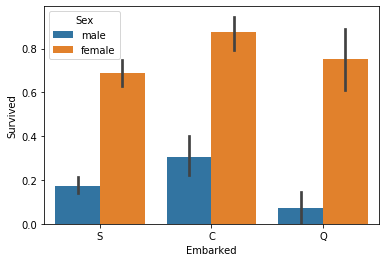

In [102]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train); 
#Since the test dataset doesn't include the survived column, we'll perform a survival analysis on the training dataset

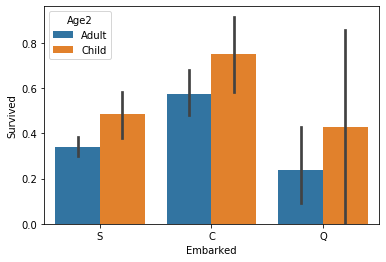

In [103]:
#Since the test dataset doesn't include the survived column, we'll perform a survival analysis on the training dataset
#Let's create a category variable to show if the passenger was a child or not base on the age (less than 18).
train.loc[train['Age'] < 18, 'Age2'] = 'Child' 
train.loc[train['Age'] >= 18, 'Age2'] = 'Adult'
test.loc[test['Age'] < 18, 'Age2'] = 'Child' 
test.loc[test['Age'] >= 18, 'Age2'] = 'Adult' 
sns.barplot(x="Embarked", y="Survived", hue="Age2", data=train);

#### We can see that women's survival rates far exceeded the men's survival rate, which means that passengers onboard the Titanic did in fact abide by the Birkenhead Drill, or Women and Children first.

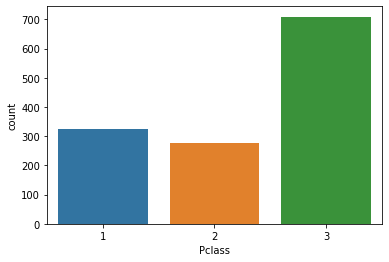

In [104]:
sns.countplot(x="Pclass", data=Titanic)
#Majority of the passengers were third class, the 2nd most passengers were first class
#and the least passengers were second class.

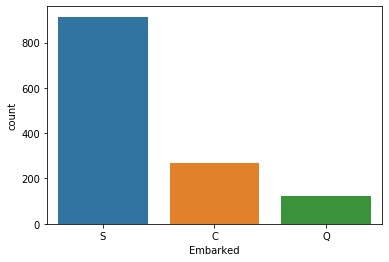

In [105]:
sns.countplot(x="Embarked", data=Titanic)
#Majority of passengers came from Southampton

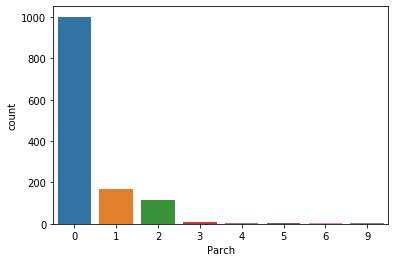

In [106]:
sns.countplot(x="Parch", data=Titanic)
#Majority of passengers were travelling without parents or children

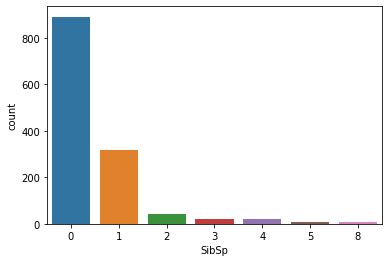

In [107]:
sns.countplot(x="SibSp", data=Titanic)
#Majority of passengers were travelling without siblings and spouses

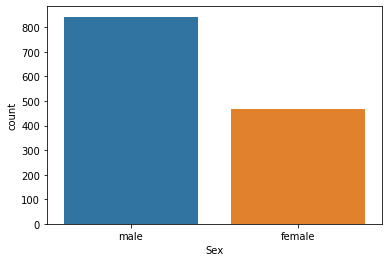

In [108]:
sns.countplot(x="Sex", data=Titanic)
#Majority of passengers were male

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

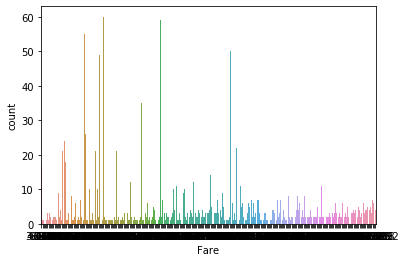

In [109]:
sns.countplot(x="Fare", data=Titanic)
Titanic['Fare'].describe()
#There's a wide range of fares that were paid, with the highest being a hefty $512. Inspecting the plot below shows that the
#majority of passengers had a fare of ~$15 or less.

#### Let's actually inspect the data and see if there's anything we need to correct before beginning the machine learning procedures.

In [110]:
print(train.shape)
print(test.shape)
print(Titanic.shape)
print(train.info())
print(test.info())
#There's a significant number of missing cabin numbers. Age is also problematic because it's missing almost 200 observations.
#Embarked is only missing 2 observations
#We're missing a few age and 1 fare in the test data as well. We'll have to impute those as well.

(891, 13)
(418, 12)
(1309, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Age2           714 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int

In [111]:
#To correct for age, we'll replace the null values with the mean age of the passengers.
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())
#Since we replaced the null values with the mean age, we'll need to reassess the child/adult transformation from above
train.loc[train['Age'] < 18, 'Age2'] = 'Child' 
train.loc[train['Age'] >= 18, 'Age2'] = 'Adult' 
test.loc[test['Age'] < 18, 'Age2'] = 'Child' 
test.loc[test['Age'] >= 18, 'Age2'] = 'Adult'
#To correct for cabin, we'll make a judgement call and replace the null values with 'S' since most passengers came from Southampton
train['Embarked'] = train['Embarked'].fillna('S')
#To correct for fare in the test set, we'll replace the null value with the mean fare.
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())


#As much as I would love to correct the cabin data, there's no good way to replace the null values. 
del train['Cabin']
del test['Cabin']
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Age2           891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null 

#### Let's change some of these categorical variables into numerical to boost the performance of the models.

In [119]:
train['Sex'].replace('female', 0, inplace=True)
train['Sex'].replace('male', 1, inplace=True)
test['Sex'].replace('female', 0, inplace=True)
test['Sex'].replace('male', 1, inplace=True)

train.loc[train['Embarked'] == 'S', 'Southampton'] = 1 
train.loc[train['Embarked'] != 'S', 'Southampton'] = 0
train.loc[train['Embarked'] == 'Q', 'Queenstown'] = 1 
train.loc[train['Embarked'] != 'Q', 'Queenstown'] = 0
test.loc[train['Embarked'] == 'S', 'Southampton'] = 1 
test.loc[train['Embarked'] != 'S', 'Southampton'] = 0
test.loc[train['Embarked'] == 'Q', 'Queenstown'] = 1 
test.loc[train['Embarked'] != 'Q', 'Queenstown'] = 0
train.loc[train['Embarked'] == 'C', 'Cherbourg'] = 1 
train.loc[train['Embarked'] != 'C', 'Cherbourg'] = 0
test.loc[train['Embarked'] == 'C', 'Cherbourg'] = 1 
test.loc[train['Embarked'] != 'C', 'Cherbourg'] = 0

train['Age2'].replace('Child', 0, inplace=True)
train['Age2'].replace('Adult', 1, inplace=True)
test['Age2'].replace('Child', 0, inplace=True)
test['Age2'].replace('Adult', 1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age2,Southampton,Queenstown,Cherbourg
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,1,1.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,1,0.0,0.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1.0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,1,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,1,1.0,0.0,0.0


#### Now that the variables are setup to be numeric, let's look at a correlation of the data to see which variables we'll select for modeling

In [121]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age2,Southampton,Queenstown,Cherbourg
PassengerId,1,-0.00500666,-0.035144,0.0429389,0.0332065,-0.0575268,-0.00165201,0.0126582,0.0248743,0.0222035,-0.0336057,-0.0012048
Survived,-0.00500666,1,-0.338481,-0.543351,-0.0698085,-0.0353225,0.0816294,0.257307,-0.122239,-0.149683,0.00365038,0.16824
Pclass,-0.035144,-0.338481,1,0.1319,-0.331339,0.0830814,0.0184427,-0.5495,-0.12562,0.0740528,0.221009,-0.243292
Sex,0.0429389,-0.543351,0.1319,1,0.0841534,-0.114631,-0.245489,-0.182333,0.10715,0.119224,-0.0741151,-0.0828535
Age,0.0332065,-0.0698085,-0.331339,0.0841534,1,-0.232625,-0.179191,0.0915661,0.605852,-0.0193356,-0.0138552,0.0320244
SibSp,-0.0575268,-0.0353225,0.0830814,-0.114631,-0.232625,1,0.414838,0.159651,-0.324068,0.0687336,-0.0263537,-0.0595282
Parch,-0.00165201,0.0816294,0.0184427,-0.245489,-0.179191,0.414838,1,0.216225,-0.31767,0.0608136,-0.0812281,-0.0110688
Fare,0.0126582,0.257307,-0.5495,-0.182333,0.0915661,0.159651,0.216225,1,0.00754621,-0.162184,-0.117216,0.269335
Age2,0.0248743,-0.122239,-0.12562,0.10715,0.605852,-0.324068,-0.31767,0.00754621,1,-0.000542565,0.0331936,-0.0232251
Southampton,0.0222035,-0.149683,0.0740528,0.119224,-0.0193356,0.0687336,0.0608136,-0.162184,-0.000542565,1,-0.499421,-0.782742


#### For sake of the model, we'll use every variable that is greater than .10 and less than -.10